# Demo for the BUTD Detector in Torch
- The image detector developped for the BUTD paper is used for the image extracter in some V&L models.   
  (BUTD: https://github.com/peteanderson80/bottom-up-attention)
- The detector works in the caffe framework, so some preparations are required, such as introducing docker.
- We converted the detector into a module for the torch framework to reduce preparations.
- This demo sees how it works.
- Note that we did not fully transplant, only made some essential parts to use it for an image extracter    
  and that we have not conducted a thorough verification for our implementation of how accurately the original model is reproduced.
- Weights are avalilabe (see README.md in the same directory)

In [1]:
# Our implementation depends on torch, numpy and PIL/cv2
import torch
import numpy as np
import PIL.Image
import cv2

from eval_vl_glue.extractor import BUTDDetector, ModelConfig

## Utility to show an image
This is just needed for this demo.

In [2]:
# Plot config
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6) 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray'

In [3]:
# function
def show_image_with_boxes(image, regions, attr_thresh=0.1):
    
    plt.imshow(image)
    lines = []
    lines.append('regions=%d' % (len(regions)))
    
    for i, region in enumerate(regions):
        
        # Make a label string
        obj_label = region.object_label + ' [%.2f]'%region.object_label_conf
        if region.attribute_label_conf > attr_thresh:
            label = f'{region.attribute_label} {obj_label}'
        else:
            label = f'{region.obj_label}'
        
        lines.append(f'box={region.box} obj={obj_label}')
        
        # Modify box boundary
        x, y, xx, yy = region.box
        x = x if x != 0 else 1
        y = y if y != 0 else 1
        
        # Draw
        plt.gca().add_patch(plt.Rectangle(
                (x, y), xx - x, yy - y,
                fill=False, edgecolor='red', linewidth=2, alpha=0.5
        ))
        plt.gca().text(
                x, y - 2, label,
                bbox=dict(facecolor='blue', alpha=0.5), fontsize=10,  color='white'
        )
    
    print(*lines, sep='\n')

## Detection with the model
We will try some setups.

In [4]:
# File path to an image to be detected
# Here, we detect from a cat image (000542.jpg) used in the demo.
image_path = '../download/000542.jpg' 

### 1. Loading image using CV2.imread and Model with BBOX_REG=False
The nearest setup to the original model.

In [5]:
# Load a model and its pretrained weight
model_path = '../download/resnet101_faster_rcnn_final.pt'
model = BUTDDetector(ModelConfig(BBOX_REG=False))
# We set this setup as a default model config, so 'model = BUTDDetector()' is idential.
model.load_state_dict(torch.load(model_path))
model = model.eval()

/remote/csifs1/disk0/iki/eval_vl_glue/eval_vl_glue/venv/lib/python3.6/site-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/remote/csifs1/disk0/iki/eval_vl_glue/eval_vl_glue/venv/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mod

regions=13
box=[ 50.291405  22.19696  386.97284  374.375   ] obj=cat [0.52]
box=[ 39.65393 196.64363 499.375   374.375  ] obj=whiskers [0.95]
box=[255.42513   12.760296 499.375    374.375   ] obj=cat [0.66]
box=[204.9098  221.32689 269.07025 263.06042] obj=nose [0.97]
box=[ 74.889    0.     330.326  323.6189] obj=face [0.68]
box=[193.72574 174.54163 283.99704 275.49344] obj=nose [0.83]
box=[197.8477  281.53345 268.6769  310.1712 ] obj=mouth [0.60]
box=[  0.      201.44916 189.79683 374.375  ] obj=whiskers [0.98]
box=[ 93.01784  64.70788 168.8723  133.23802] obj=eye [0.89]
box=[293.70425  65.53982 368.89728 136.72464] obj=eye [0.85]
box=[280.295   181.07997 499.375   304.32874] obj=whiskers [0.92]
box=[ 88.808556 256.7181   175.49506  335.7365  ] obj=whiskers [0.41]
box=[108.51269   31.423693 398.74014  140.73805 ] obj=eyes [0.98]


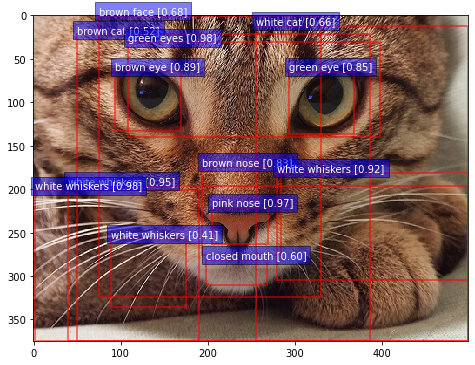

In [6]:
#  input a ndarray with RGB order in the last axis.
image = cv2.imread(image_path)[:,:,::-1]
# detect function returns a list of DetectedRegion objects
regions = model.detect(image, conf_thresh=0.4, min_boxes=10, max_boxes=20)
show_image_with_boxes(image, regions, attr_thresh=0.1)

- The result is almost the same (the number of detected regions, object label and attribute label),   
  but box sizes are different from the demo to some extent.
- We think fine-tuning is desirable to mitigate this difference for the models pre-trained with the original detector.
- The reason is not clear, it might be that forward calculation of DNN is not identical between frameworks.

In [7]:
# we can access the feature for a region from 
# the feature attribute of the DetectedRegion class
print(type(regions[0].feature), regions[0].feature.shape)

<class 'numpy.ndarray'> (2048,)


### 2. Loading image using PIL.Image.open and Model with BBOX_REG=False
- We used the cv2 imread in the above detetion (this was the same as the demo)
- When we use the PIL Image, the result changes because the loaded pixel data is different slightly.

regions=12
box=[ 51.388397  22.77443  386.35043  374.375   ] obj=cat [0.51]
box=[ 39.660454 196.02148  499.375    374.375   ] obj=whiskers [0.95]
box=[255.81047   12.336769 499.375    374.375   ] obj=cat [0.65]
box=[204.68187 221.22476 269.22064 262.95425] obj=nose [0.97]
box=[ 61.532192   0.       331.72058  343.2347  ] obj=face [0.66]
box=[193.20764 174.44101 284.19104 275.40826] obj=nose [0.84]
box=[  0.      206.2326  209.24957 321.22586] obj=whiskers [0.98]
box=[197.9806  281.59958 268.71048 310.17712] obj=mouth [0.60]
box=[293.80963  65.80931 368.40933 136.34096] obj=eye [0.85]
box=[ 93.08309  65.13376 168.82938 133.39888] obj=eye [0.89]
box=[289.36978 169.9824  451.8648  330.1186 ] obj=whiskers [0.88]
box=[107.78416   31.727776 400.41183  141.91986 ] obj=eyes [0.97]


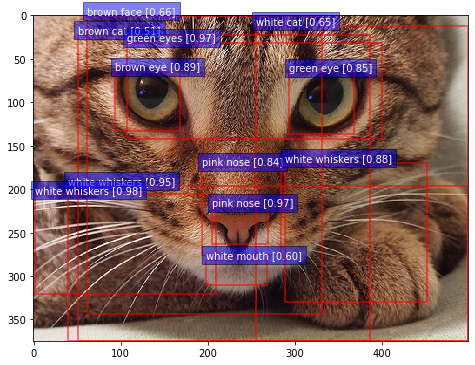

In [8]:
image = PIL.Image.open(image_path)
regions = model.detect(image, conf_thresh=0.4, min_boxes=10, max_boxes=20)
show_image_with_boxes(image, regions, attr_thresh=0.1)

### 3. Model with BBOX_REG=True 
- The next one is the output when BBOX_REG is set True according to the test configuration.  
- BBOX_REG fine-tunes a detected box for each candidate class.

regions=11
box=[ 13.745209 199.71582  476.7687   361.21436 ] obj=whiskers [0.95]
box=[ 84.275055   4.768982 496.27097  346.95508 ] obj=cat [0.65]
box=[201.22359 219.23749 276.7093  266.70782] obj=nose [0.97]
box=[ 44.59175   21.388641 432.6042   317.09784 ] obj=face [0.66]
box=[176.33908 158.99252 295.3724  276.50192] obj=nose [0.63]
box=[  0.      215.74803 169.2178  346.0199 ] obj=whiskers [0.98]
box=[190.65997 281.01724 271.70645 312.33774] obj=mouth [0.60]
box=[301.4296   56.38978 371.90085 133.3909 ] obj=eye [0.85]
box=[102.1133    55.681587 172.29167  133.9361  ] obj=eye [0.89]
box=[ 87.80969  41.88658 400.97656 151.49544] obj=eyes [0.97]
box=[318.82285 193.93762 479.70944 333.96088] obj=whiskers [0.87]


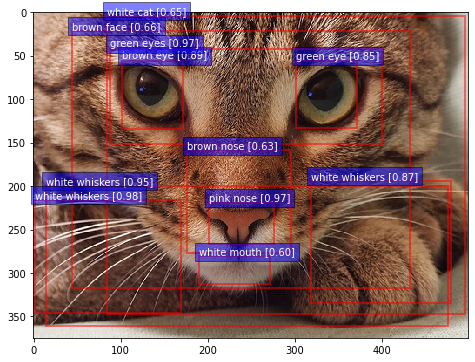

In [9]:
model_path = '../download/resnet101_faster_rcnn_final.pt'
model = BUTDDetector(ModelConfig(BBOX_REG=True))
model.load_state_dict(torch.load(model_path))
model = model.eval()

image = PIL.Image.open(image_path)
regions = model.detect(image, conf_thresh=0.4, min_boxes=10, max_boxes=20)
show_image_with_boxes(image, regions, attr_thresh=0.1)

### 4. Detecting from a dummy image
- The last result is on the detection with a black monochrome image

regions=36
box=[  0.        0.      223.62666 119.81898] obj=sky [0.68]
box=[  0.        34.950714 131.44263  223.62666 ] obj=sky [0.35]
box=[ 77.77673  35.87647 223.62666 223.62666] obj=sky [0.35]
box=[  0.        0.      210.08043 200.70609] obj=sky [0.56]
box=[ 73.55119   12.275655 169.69508   92.7994  ] obj=sky [0.17]
box=[ 37.082096  71.296684 190.63286  149.08218 ] obj=sky [0.11]
box=[ 22.762592   4.949888 113.35856   78.87903 ] obj=sky [0.09]
box=[ 34.782593  12.141365 223.62666  223.62666 ] obj=sky [0.51]
box=[  0.      148.13364 223.62666 223.62666] obj=background [0.05]
box=[121.07566    4.457285 207.89674   77.00012 ] obj=sky [0.05]
box=[  0.         0.       211.70142   31.606623] obj=sky [0.03]
box=[ 33.814415 133.2707   196.57344  209.3551  ] obj=sky [0.03]
box=[ 36.994778  54.867653 189.54883  137.03178 ] obj=sky [0.23]
box=[  0.         6.593253 153.18924   87.99892 ] obj=sky [0.36]
box=[ 22.691734  71.17294  223.62666  223.62666 ] obj=sky [0.34]
box=[ 20.807028  99.641

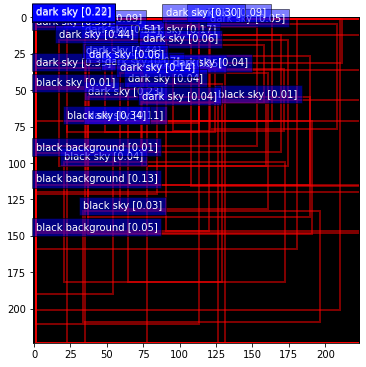

In [10]:
model_path = '../download/resnet101_faster_rcnn_final_iter_320000.pt'
model = BUTDDetector()
model.load_state_dict(torch.load(model_path))
model = model.eval()

image = np.zeros((224, 224, 3), dtype=np.uint8)
regions = model.detect(image)
show_image_with_boxes(image, regions, attr_thresh=0.1)